<div style="text-align: right">Peter Norvig, 3 Oct 2015, revised Oct-Feb 2016</div> 

# Probability, Paradox, and the Reasonable Person Principle

In [another notebook](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb), I introduced the basics of probability theory. I'll duplicate the code we developed there:

In [1]:
from fractions import Fraction

class ProbDist(dict):
    "A Probability Distribution; an {outcome: probability} mapping."
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            self[outcome] = self[outcome] / total
            assert self[outcome] >= 0
            
def P(event, space): 
    """The probability of an event, given a sample space of equiprobable outcomes. 
    event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
    space: a set of outcomes or a probability distribution of {outcome: frequency}."""
    if is_predicate(event):
        event = such_that(event, space)
    if isinstance(space, ProbDist):
        return sum(space[o] for o in space if o in event)
    else:
        return Fraction(len(event & space), len(space))
    
def such_that(predicate, space): 
    """The outcomes in the sample space for which the predicate is true.
    If space is a set, return a subset {outcome,...};
    if space is a ProbDist, return a ProbDist {outcome: frequency,...};
    in both cases only with outcomes where predicate(element) is true."""
    if isinstance(space, ProbDist):
        return ProbDist({o:space[o] for o in space if predicate(o)})
    else:
        return {o for o in space if predicate(o)}
    
is_predicate = callable

def cross(A, B):
    "The set of ways of concatenating one item from collection A with one from B."
    return {a + b 
            for a in A for b in B}

def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for a in A
                    for b in B})

In this notebook we use this code to show how to solve some particularly perplexing paradoxical probability problems.

# Child Paradoxes

In 1959, [Martin Gardner]() [posed](https://en.wikipedia.org/wiki/Boy_or_Girl_paradox) these two problems:

- **Child Problem 1.** Mr. Jones has two children. The older child is a boy. What is the
probability that both children are boys?

- **Child Problem 2.** Mr. Smith has two children. At least one of them is a boy. What is
the probability that both children are boys? 

Then in 2006, Mike & Tom Starbird came up with a variant, which Gary Foshee introduced to Gardner fans in 2010:

- **Child Problem 3.** I have two children. At least one of them is a boy born on Tuesday. What is
the probability that both children are boys? 

Problems 2 and 3 are considered *paradoxes* because they have surprising answers that people
argue about. 

(Assume the probability of a boy is exactly 1/2, and is independent of any siblings.)

![Martin Gardner](https://upload.wikimedia.org/wikipedia/commons/0/04/Martin_Gardner.jpeg)
<center>Martin Gardner</center>

### Child Problem 1: Older child is a boy. What is the probability both are boys?

We use `'BG'` to denote the outcome in which the older child is a boy and the younger a girl. The sample space, `S`, of equi-probable outcomes is:

In [2]:
S = {'BG', 'BB', 'GB', 'GG'}

Let's define predicates for the conditions of having two boys, and of the older child being a boy:

In [3]:
def two_boys(outcome): return outcome.count('B') == 2

def older_is_a_boy(outcome): return outcome.startswith('B')

Now we can answer Problem 1:

In [4]:
P(two_boys, such_that(older_is_a_boy, S))

Fraction(1, 2)

You're probably thinking that was a lot of mechanism just to get the obvious answer. But in the next problems, what is obvious becomes less obvious.

### Child Problem 2: At least one is a boy. What is the probability both are boys? 

Implementing this problem and finding the answer is easy:

In [5]:
def at_least_one_boy(outcome): return 'B' in outcome

In [6]:
P(two_boys, such_that(at_least_one_boy, S))

Fraction(1, 3)

Understanding the answer is tougher. Some people think the answer should be 1/2. Can we justify the answer 1/3?  We can see there are three equiprobable outcomes in which there is at least one boy:

In [7]:
such_that(at_least_one_boy, S)

{'BB', 'BG', 'GB'}

Of those three outcomes, only one has two boys, so the answer of 1/3 is indeed justified. 

But some people *still* think the answer should be 1/2.
Their reasoning is *"If one child is a boy, then there are two equiprobable outcomes for the other child, so the probability that the other child is a boy, and thus that there are two boys, is 1/2."* 

When two methods of reasoning give two different answers, we have a [paradox](https://en.wikipedia.org/wiki/Paradox). Here are three responses to a paradox:

1. The very fundamentals of mathematics must be incomplete, and this problem reveals it!!!
2. I'm right, and anyone who disagrees with me is an idiot!!!
3. I have the right answer for one interpretation of the problem, and you have the right answer
for a different interpretation of the problem.

If you're [Bertrand Russell](https://en.wikipedia.org/wiki/Russell%27s_paradox) or [Georg Cantor](https://en.wikipedia.org/wiki/Cantor%27s_paradox), you might very well uncover a fundamental flaw in mathematics; for the rest of us, I recommend Response 3. When I believe the answer is 1/3, and I hear someone say the answer is 1/2, my response is not *"You're wrong!"*, rather it is *"How interesting! You must have a different interpretation of the problem; I should try to discover what your interpretation is, and why your answer is correct for your interpretation."* The first step is to be more precise in *my* wording of the experiment:

- **Child Experiment 2a.** Mr. Smith is chosen at random from families with two children. He is asked if at least one of his children is a boy. He replies "yes."

The next step is to envision another possible interpretation of the experiment:

- **Child Experiment 2b.** Mr. Smith is chosen at random from families with two children. He is observed at a time when he is accompanied by one of his children, chosen at random. The child is observed to be a boy.  

Experiment 2b needs a different sample space, which we will call `S2b`.  It consists of 8 outcomes, not just 4; for each of the 4 outcomes in `S`, we have a choice of observing either the older child or the younger child.  We will use the notation `'GB/g?'` to mean that the older child is a girl, the younger a boy, the older child was observed to be a girl, and the younger was not observed. The sample space is therefore:

In [8]:
S2b = {'BB/b?', 'BB/?b', 
       'BG/b?', 'BG/?g', 
       'GB/g?', 'GB/?b', 
       'GG/g?', 'GG/?g'}

Now we can figure out the subset of this sample space in which we observe Mr. Smith with a boy:

In [9]:
def observed_boy(outcome): return 'b' in outcome

such_that(observed_boy, S2b)

{'BB/?b', 'BB/b?', 'BG/b?', 'GB/?b'}

And finally we can determine the probability that he has two boys, given that we observed him with a boy:

In [10]:
P(two_boys, such_that(observed_boy, S2b))

Fraction(1, 2)

The paradox is resolved. Two reasonable people can have different interpretations of the problem, and can each reason flawlessly to reach different conclusions, 1/3 or 1/2. 

Which interpretation of the problem is "better?"  We could debate that, or we could just agree to use unambiguous wording (that is, use the language of Experiment 2a or Experiment 2b, not the ambiguous language of Problem 2). 

## The Reasonable Person Principle

It is an unfortunate fact of human nature that we often assume the other person is an idiot. As [George Carlin puts it](https://www.youtube.com/watch?v=XWPCE2tTLZQ) *"Have you ever noticed when you're driving that anybody driving slower than you is an idiot, and anyone going faster than you is a maniac?"*

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Jesus_is_coming.._Look_Busy_%28George_Carlin%29.jpg/192px-Jesus_is_coming.._Look_Busy_%28George_Carlin%29.jpg">
<center>George Carlin</center>

The opposite assumption&mdash;that other people are more likely to be **reasonable** rather than **idiots** is known as the **[reasonable person principle](http://www.cs.cmu.edu/~weigand/staff/)**. It is a guiding principle at Carnegie Mellon University's School of Computer Science, and is a principle I try to live by as well.

Now let's return to an even more paradoxical problem.

### Child Problem 3. One is a boy born on Tuesday. What's the probability  both are boys?

Most people can not imagine how the boy's birth-day-of-week could be relevant, and feel the answer should be the same as Problem 2.  But to be sure, we need to clearly describe the experiment, define the sample space, and calculate.  First:

- **Child Experiment 3a.** A parent is chosen at random from families with two children. She is asked if at least one of her children is a boy born on Tuesday. She replies "yes."

Next we'll define a sample space. We'll use the notation "`G1B3`" to mean the older child is a girl born on the first day of the week (Sunday) and the younger a boy born on the third day of the week (Tuesday). We'll call the resulting sample space `S3`.

In [11]:
sexesdays = cross('BG', '1234567')
S3 = cross(sexesdays, sexesdays)
len(S3)

196

That's too many to print, but we can sample them:

In [12]:
import random
random.sample(S3, 8)

['G2G3', 'G6B7', 'B1G7', 'B4B7', 'B4G6', 'G5G5', 'B5G4', 'G4B4']

We determine below that the probability of having at least one boy is 3/4, both in `S3` (where we keep track of the birth day of week) and in `S` (where we don't):

In [13]:
P(at_least_one_boy, S3)

Fraction(3, 4)

In [14]:
P(at_least_one_boy, S)

Fraction(3, 4)

The probability of two boys is 1/4 in either sample space:

In [15]:
P(two_boys, S3)

Fraction(1, 4)

In [16]:
P(two_boys, S)

Fraction(1, 4)

And the probability of two boys given at least one boy is 1/3 in either sample space:

In [17]:
P(two_boys, such_that(at_least_one_boy, S3))

Fraction(1, 3)

In [18]:
P(two_boys, such_that(at_least_one_boy, S))

Fraction(1, 3)

We will define a predicate for the event of at least one boy born on Tuesday: 

In [19]:
def at_least_one_boy_tues(outcome): return 'B3' in outcome

We are now ready to answer Problem 3:

In [20]:
P(two_boys, such_that(at_least_one_boy_tues, S3))

Fraction(13, 27)

13/27? 

How many saw that coming? 13/27 is quite different from 1/3, but rather close to 1/2. So "at least one boy born on Tuesday" is quite different from "at least one boy." Are you surprised? Do you accept the answer, or do you think we did something wrong? Are there other interpretations of the experiment that lead to other answers?

Here is one alternative interpretation:

- **Child Experiment 3b.** A parent is chosen at random from families with two children. She is observed at a time when she is accompanied by one of her children, chosen at random. The child is observed to be a boy who reports that his birth day is Tuesday.

We can represent outcomes in this sample space with the notation `G1B3/??b3`, meaning the older child is a girl born on Sunday, the younger a boy born on Tuesday, the older was not observed, and the younger was.

In [21]:
def observed_boy_tues(outcome): return 'b3' in outcome

S3b = {children + '/' + observation
       for children in S3
       for observation in (children[:2].lower()+'??', '??'+children[-2:].lower())}                        

In [22]:
random.sample(S3b, 5)

['G4G5/??g5', 'B1B5/b1??', 'G6G4/g6??', 'B1G2/??g2', 'G5G6/g5??']

Now we can answer this version of  Child Problem 3:

In [23]:
P(two_boys, such_that(observed_boy_tues, S3b))

Fraction(1, 2)

So with the wording of Child Experiment 3b, the answer is the same as 2b.

Still confused? Let's build a visualization tool to make things more concrete.

# Visualization

We'll display the results as a two dimensional grid of outcomes. An outcome will be colored white if it does not satisfy the condition stated in the problem; green if the outcome contains two boys; and yellow if it does satisfy the condition, but does not have two boys. Every cell in a row has the same older child, and every cell in a column has the same younger child. Here's the code to display a table:

In [24]:
from IPython.display import HTML

def Pgrid(space, n, event, condition):
    """Display sample space in a grid, color-coded: green if event and condition is true; 
    yellow if only condition is true; white otherwise."""
    # n is the number of characters that make up the older child.
    olders = sorted(set(outcome[:n] for outcome in space))
    return HTML('<table>' +
                cat(row(older, space, event, condition) for older in olders) +
                '</table>' + 
                '<tt>P({} | {}) = {}</tt>'.format(
                event.__name__, condition.__name__, 
                P(event, such_that(condition, space))))

def row(older, space, event, condition):
    "Display a row where an older child is paired with each of the possible younger children."
    thisrow = sorted(outcome for outcome in space if outcome.startswith(older))
    return '<tr>' + cat(cell(outcome, event, condition) for outcome in thisrow) + '</tr>'

def cell(outcome, event, condition): 
    "Display outcome in appropriate color."
    color = ('lightgreen' if event(outcome) and condition(outcome) else
             'yellow' if condition(outcome) else
             'white')
    return '<td style="background-color: {}">{}</td>'.format(color, outcome)    

cat = ''.join

We can use this visualization tool to see that in Child Problem 1, there is one outcome with two boys (green) out of a total of two outcomes where the older is a boy (green and yellow) so the probability of two boys given that the older is a boy is 1/2.

In [25]:
# Child Problem 1
Pgrid(S, 1, two_boys, older_is_a_boy)

BB,BG
GB,GG


For Child Problem 2, we see the probability of two boys (green) given at least one boy (green and yellow)  is 1/3. 

In [26]:
# Child Problem 2
Pgrid(S, 1, two_boys, at_least_one_boy)

BB,BG
GB,GG


The answer is still 1/3 when we consider the day of the week of each birth. 

In [27]:
# Child Problem 2, with days of week enumerated
Pgrid(S3, 2, two_boys, at_least_one_boy)

B1B1,B1B2,B1B3,B1B4,B1B5,B1B6,B1B7,B1G1,B1G2,B1G3,B1G4,B1G5,B1G6,B1G7
B2B1,B2B2,B2B3,B2B4,B2B5,B2B6,B2B7,B2G1,B2G2,B2G3,B2G4,B2G5,B2G6,B2G7
B3B1,B3B2,B3B3,B3B4,B3B5,B3B6,B3B7,B3G1,B3G2,B3G3,B3G4,B3G5,B3G6,B3G7
B4B1,B4B2,B4B3,B4B4,B4B5,B4B6,B4B7,B4G1,B4G2,B4G3,B4G4,B4G5,B4G6,B4G7
B5B1,B5B2,B5B3,B5B4,B5B5,B5B6,B5B7,B5G1,B5G2,B5G3,B5G4,B5G5,B5G6,B5G7
B6B1,B6B2,B6B3,B6B4,B6B5,B6B6,B6B7,B6G1,B6G2,B6G3,B6G4,B6G5,B6G6,B6G7
B7B1,B7B2,B7B3,B7B4,B7B5,B7B6,B7B7,B7G1,B7G2,B7G3,B7G4,B7G5,B7G6,B7G7
G1B1,G1B2,G1B3,G1B4,G1B5,G1B6,G1B7,G1G1,G1G2,G1G3,G1G4,G1G5,G1G6,G1G7
G2B1,G2B2,G2B3,G2B4,G2B5,G2B6,G2B7,G2G1,G2G2,G2G3,G2G4,G2G5,G2G6,G2G7
G3B1,G3B2,G3B3,G3B4,G3B5,G3B6,G3B7,G3G1,G3G2,G3G3,G3G4,G3G5,G3G6,G3G7
G4B1,G4B2,G4B3,G4B4,G4B5,G4B6,G4B7,G4G1,G4G2,G4G3,G4G4,G4G5,G4G6,G4G7




Now for the paradox of Child Problem 3:

In [28]:
# Child Problem 3
Pgrid(S3, 2, two_boys, at_least_one_boy_tues)

B1B1,B1B2,B1B3,B1B4,B1B5,B1B6,B1B7,B1G1,B1G2,B1G3,B1G4,B1G5,B1G6,B1G7
B2B1,B2B2,B2B3,B2B4,B2B5,B2B6,B2B7,B2G1,B2G2,B2G3,B2G4,B2G5,B2G6,B2G7
B3B1,B3B2,B3B3,B3B4,B3B5,B3B6,B3B7,B3G1,B3G2,B3G3,B3G4,B3G5,B3G6,B3G7
B4B1,B4B2,B4B3,B4B4,B4B5,B4B6,B4B7,B4G1,B4G2,B4G3,B4G4,B4G5,B4G6,B4G7
B5B1,B5B2,B5B3,B5B4,B5B5,B5B6,B5B7,B5G1,B5G2,B5G3,B5G4,B5G5,B5G6,B5G7
B6B1,B6B2,B6B3,B6B4,B6B5,B6B6,B6B7,B6G1,B6G2,B6G3,B6G4,B6G5,B6G6,B6G7
B7B1,B7B2,B7B3,B7B4,B7B5,B7B6,B7B7,B7G1,B7G2,B7G3,B7G4,B7G5,B7G6,B7G7
G1B1,G1B2,G1B3,G1B4,G1B5,G1B6,G1B7,G1G1,G1G2,G1G3,G1G4,G1G5,G1G6,G1G7
G2B1,G2B2,G2B3,G2B4,G2B5,G2B6,G2B7,G2G1,G2G2,G2G3,G2G4,G2G5,G2G6,G2G7
G3B1,G3B2,G3B3,G3B4,G3B5,G3B6,G3B7,G3G1,G3G2,G3G3,G3G4,G3G5,G3G6,G3G7
G4B1,G4B2,G4B3,G4B4,G4B5,G4B6,G4B7,G4G1,G4G2,G4G3,G4G4,G4G5,G4G6,G4G7


We see there are 27 relevant outcomes, of which 13 are green. So 13/27 really does seem to be the right answer. This picture also gives us a way to think about why the answer is not 1/3. Think of the yellow-plus-green area as a horizontal stripe and a vertical stripe, with an overlap. Each stripe is half yellow and half green, so if there were no overlap at all, the probability of green would be 1/2.  When each stripe takes up half the sample space and the overlap is maximal, the probability is 1/3. And in the Problem 3 table, where the overlap is small, the probability is close to 1/2 (but slightly smaller).

One way to look at it is that if I tell you very specific information (such as a boy born on Tuesday), it is unlikely that this applies to both children, so we have smaller overlap and a probability closer to 1/2, but if I give you broad information (a boy), this is more likely to apply to either child, resulting in a larger overlap, and a probability closer to 1/3.

You can read some more discussions of the problem by (in alphabetical order) 
[Alex Bellos](https://www.newscientist.com/article/dn18950-magic-numbers-a-meeting-of-mathemagical-tricksters?full=true),
[Alexander Bogomolny](http://www.cut-the-knot.org/Probability/BearBornOnTuesday.shtml),
[Andrew Gelman](http://andrewgelman.com/2010/05/27/hype_about_cond/),
[David Bigelow](https://web.viu.ca/bigelow2/Problem%201127%20Solution.pdf),
[Julie Rehmeyer](https://www.sciencenews.org/article/when-intuition-and-math-probably-look-wrong),
[Keith Devlin](https://www.maa.org/external_archive/devlin/devlin_05_10.html),
[Peter Lynch](http://mathsci.ucd.ie/~plynch/Publications/BIMS-TwoChildParadox.pdf),
[Tanya Khovanova](http://arxiv.org/pdf/1102.0173v1.pdf),
and
[Wendy Taylor &amp; Kaye Stacey](http://www.aamt.edu.au/Journals/Sample-articles/amt70_2_taylor.pdf).

# The Sleeping Beauty Paradox

The [Sleeping Beauty Paradox](https://en.wikipedia.org/wiki/Sleeping_Beauty_problem) is another tricky one:

>Sleeping Beauty volunteers to undergo the following experiment and is told all of the following details: On Sunday she will be put to sleep. Then a fair coin will be tossed,
to determine which experimental procedure to undertake:
- Heads: Beauty will be awakened and interviewed on Monday only.
- Tails: Beauty will be awakened and interviewed on Monday and Tuesday only.

>In all cases she is put back to sleep with an amnesia-inducing drug that makes her forget that awakening and sleep until the next one. In any case, she will be awakened on Wednesday without interview and the experiment ends. Any time Beauty is awakened and interviewed, she is asked, "What is your belief now for the proposition that the coin landed heads?"

What should Sleeping Beauty say when she is interviewed?  First, she should define the sample space.  She could use the notation `'heads/Monday/interviewed'` to mean the outcome where the coin flip was heads, it is Monday, and she is interviewed. So there are 4 equiprobable outcomes:

In [29]:
B = {'heads/Monday/interviewed', 'heads/Tuesday/sleep',
     'tails/Monday/interviewed', 'tails/Tuesday/interviewed'}

At this point, you're probably expecting me to define predicates, like this:

    def heads(outcome): return 'heads' in outcome
    def interviewed(outcome): return 'interviewed' in outcome
    
We've seen a lot of predicates like this. I think it is time to heed the "[don't repeat yourself](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself)" principle, so I will define a predicate-defining function, `T`. Think of "`T`" for "it is true that":

In [30]:
def T(property):
    "Return a predicate that is true of all outcomes that have 'property' as a substring."
    return lambda outcome: property in outcome

Now we can get the answer:

In [31]:
heads = T("heads")
interviewed = T("interviewed")

P(heads, such_that(interviewed, B))

Fraction(1, 3)

Note: I could have done that in one line: `P(T("heads"), such_that(T("interviewed"), B))`

This problem is considered a paradox because there are people who argue that the answer should be 1/2, not 1/3. I admit I'm having difficulty coming up with a sample space that supports the "halfer" position. 

I do know of a question that has the answer 1/2:

In [32]:
P(heads, B) 

Fraction(1, 2)

But that seems like the wrong question; we want the probability of heads given that Sleeping Beauty was interviewed, not the unconditional probability of heads.

The "halfers" argue that before Sleeping Beauty goes to sleep, her unconditional probability for heads should be 1/2. When she is interviewed, she doesn't know anything more than before she went to sleep, so nothing has changed, so the probability of heads should still be 1/2. I find two flaws with this argument. First, if you want to convince me, show me a sample space; don't just make philosophical arguments. (Although a philosophical argument can be employed to help you define the right sample space.) Second, while I agree that before she goes to sleep, Beauty's *unconditional* probability for heads should be 1/2, I would say that both before she goes to sleep and when she is awakened, her *conditional* probability of heads *given that she is being interviewed* should be 1/3, as shown by the sample space.

# The Monty Hall Paradox

[This](https://en.wikipedia.org/wiki/Monty_Hall_problem) is one of the most famous probability paradoxes. It can be stated as follows:

> Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to switch your choice to door No. 2?" Is it to your advantage to switch your choice?

<img src="http://retrothing.typepad.com/.a/6a00d83452989a69e20120a4cb10a2970b-800wi">
<center>Monty Hall</center>

Much has been written about this problem, but to solve it all we have to do is be careful about how we understand the problem, and about defining our sample space.  I will define outcomes of the form `'Car1/Lo/Pick1/Open2'`, which means:
* `Car1`: The producers of the show randomly placed the car behind door 1.
* `Lo`: The host randomly commits to the strategy of opening the lowest-numbered allowable door. A door is allowable if it does not contain the car and was not picked by the contestant. Alternatively, the host could have chosen to open the highest-numbered allowable door (`Hi`).
* `Pick1`: The contestant picks door 1.  Our sample space will only consider cases where the contestant picks door 1, but by symmetry, the same arguments could be used if the contestant picked door 2 or 3.
* `Open2`: After hearing the contestant's choice, and following the strategy, the host opens a door; in this case door 2.

We can see that the sample space has 6 equiprobable outcomes involving `Pick1`:

In [33]:
M = {'Car1/Lo/Pick1/Open2', 'Car1/Hi/Pick1/Open3',
     'Car2/Lo/Pick1/Open3', 'Car2/Hi/Pick1/Open3',
     'Car3/Lo/Pick1/Open2', 'Car3/Hi/Pick1/Open2'}

Now, assuming the contestant picks door 1 and the host opens door 3, we can ask:
- What are the possible outcomes remaining?
- What is the probability that the car is behind door 1? 
- Or door 2?

In [34]:
such_that(T("Open3"), M)

{'Car1/Hi/Pick1/Open3', 'Car2/Hi/Pick1/Open3', 'Car2/Lo/Pick1/Open3'}

In [35]:
P(T("Car1"), such_that(T("Open3"), M))

Fraction(1, 3)

In [36]:
P(T("Car2"), such_that(T("Open3"), M))

Fraction(2, 3)

We see that the strategy of **switching** from door 1 to door 2 will win the car 2/3 of the time, whereas the strategy of **sticking** with the original pick wins the car only 1/3 of the time. So if you like cars more than goats, you should switch. But don't feel bad if you got this one wrong; it turns out that Monty Hall himself, who opened many doors while hosting *Let's Make a Deal* for 13 years, didn't know the answer either, as revealed in this letter from Monty to Prof. Lawrence Denenberg, when Denenberg asked for permission to use the problem in his textbook:
<img src="http://norvig.com/monty-hall-letter.jpg">

If you were Denenberg, how would you answer Monty, in non-mathematical terms?  I would try something like this:

> When the contestant makes her initial pick, she has 1/3 chance of picking the car, and there is a 2/3 chance the car is behind one of the other doors. That's still true after you open a door, but now the 2/3 chance for *either* other door becomes concentrated as 2/3 behind *one* other door, so the contestant should switch.

But that type of argument was not persuasive to everyone. [Marilyn vos Savant](http://marilynvossavant.com/game-show-problem/) reports that many of her readers (including, she is pleased to point out, many Ph.D.s) still insist the answer is that it doesn't matter if the contestant switches; the odds are 1/2 either way. Let's try to discover what problem and what sample space those people are dealing with. Perhaps they are reasoning like this:

They define outcomes of the form `'Car1/Pick1/Open2/Goat'`, which means:
* `Car1`: First the car is randomly placed behind door 1.
* `Pick1`: The contestant picks door 1.  
* `Open2`: The host opens one of the two other doors at random (so the host might open the door with the car).
* `Goat`: We observe there is a goat behind the opened door.

Under this interpretation, the sample space of all outcomes involving `Pick1` is:

In [37]:
M2 = {'Car1/Pick1/Open2/Goat', 'Car1/Pick1/Open3/Goat',
      'Car2/Pick1/Open2/Car',  'Car2/Pick1/Open3/Goat',
      'Car3/Pick1/Open2/Goat', 'Car3/Pick1/Open3/Car'}

And we can calculate the probability of the car being behind each door, given that the contestant picks door 1 and the host opens door 3 to reveal a goat:

In [38]:
P(T("Car1"), such_that(T("Open3/Goat"), M2))

Fraction(1, 2)

In [39]:
P(T("Car2"), such_that(T("Open3/Goat"), M2))

Fraction(1, 2)

In [40]:
P(T("Car3"), such_that(T("Open3/Goat"), M2))

Fraction(0, 1)

So we see that under this interpretation it doesn't matter if you switch or not. 

Is this a valid interpretation? I agree that the wording of the problem can be seen as being ambiguous. However, this interpretation has a serious problem: in all the history of *Let's Make a Deal*, it was never the case that the host opened up a door with the grand prize.  This strongly suggests (but does not prove) that `M`  is the correct sample space, not `M2`

# Simulating the Monty Hall Problem

Some people might be more convinced by a simulation than by a probability argument. Here is code for a simulation:

In [41]:
import random


def monty(strategy):
    """Simulate this sequence of events:
    1. The host randomly chooses a door for the 'car'
    2. The contestant randomly makes a 'pick' of one of the doors
    3. The host randomly selects a non-car, non-pick door to be 'opened.' 
    4. If strategy == 'switch', contestant changes 'pick' to the other unopened door
    5. Return true if the pick is the door with the car."""
    doors  = (1, 2, 3)
    car    = random.choice(doors)
    pick   = random.choice(doors)
    opened = random.choice([d for d in doors if d != car and d != pick])
    if strategy == 'switch':
        pick = next(d for d in doors if d != pick and d != opened)
    return (pick == car)

We can confirm that the contestant wins about 2/3 of the time with the `switch` strategy, and only wins about 1/3 of the time with the `stick` strategy:

In [42]:
from collections import Counter

Counter(monty('switch') for _ in range(10 ** 5))

Counter({False: 33110, True: 66890})

In [43]:
Counter(monty('stick') for _ in range(10 ** 5))

Counter({False: 66738, True: 33262})

# Reasoning with Probability Distributions

So far, we have made the assumption that every outcome in a sample space is equally likely. In real life, the probability of a child being a girl is not exactly 1/2. As mentioned in the [previous notebook](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb), an [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) gives the following counts for two-child families in Denmark:

    GG: 121801    GB: 126840
    BG: 127123    BB: 135138

Let's implement that:

In [44]:
DK = ProbDist(GG=121801, GB=126840,
              BG=127123, BB=135138)
DK

{'BB': 0.2645086533229465,
 'BG': 0.24882071317004043,
 'GB': 0.24826679089140383,
 'GG': 0.23840384261560926}

Now let's try the first two Child Problems with the probability distribution `DK`. Since boys are slightly more probable than girls, we expect a little over 1/2 for Problem 1, and a little over 1/3 for problem 2:

In [45]:
# Child Problem 1 in DK
P(two_boys, such_that(older_is_a_boy, DK))

0.5152805792702689

In [46]:
# Child Problem 2 in DK
P(two_boys, such_that(at_least_one_boy, DK))

0.3473082824253857

It all looks good. Now let's leave Denmark behind and try a new problem:

### Child Problem 4. One is a boy born on Feb. 29. What is the probability both are boys?

* **Child Problem 4.** I have two children. At least one of them is a boy born on leap day, February 29. What is the probability that both children are boys? Assume that 51.5% of births are boys and that birth days are distributed evenly across the 4&times;365 + 1 days in a 4-year cycle.

We will use the notation `GLBN` to mean an older girl born on leap day (`L`) and a younger boy born on a non-leap day (`N`). 

In [47]:
sexes = ProbDist(B=51.5, G=48.5)   # Probability distribution over sexes
days  = ProbDist(L=1, N=4*365)     # Probability distribution over Leap days and Non-leap days
child = joint(sexes, days)         # Probability distribution for one child family
S4    = joint(child, child)        # Probability distribution for two-child family

Let's check out these last two probability distributions:

In [48]:
child

{'BL': 0.00035249828884325804,
 'BN': 0.5146475017111568,
 'GL': 0.0003319644079397673,
 'GN': 0.48466803559206023}

In [49]:
S4

{'BLBL': 1.2425504363742495e-07,
 'BLBN': 0.00018141236371064045,
 'BLGL': 1.170168857556332e-07,
 'BLGN': 0.0001708446532032245,
 'BNBL': 0.00018141236371064045,
 'BNBN': 0.26486205101753507,
 'BNGL': 0.00017084465320322452,
 'BNGN': 0.24943319367670777,
 'GLBL': 1.170168857556332e-07,
 'GLBN': 0.00017084465320322452,
 'GLGL': 1.102003681388002e-07,
 'GLGN': 0.0001608925374826483,
 'GNBL': 0.0001708446532032245,
 'GNBN': 0.24943319367670777,
 'GNGL': 0.0001608925374826483,
 'GNGN': 0.2349031047246665}

Now we can solve the problem. Since "boy born on a leap day" applies to so few children, we expect the probability of two boys to be just ever so slightly below the baseline rate for boys, 51.5%.

In [50]:
# Child Problem 4
boy_born_on_leap_day = T("BL")

P(two_boys, such_that(boy_born_on_leap_day, S4))

0.5149145040963757

# The St. Petersburg Paradox

The [St. Petersburg paradox](https://en.wikipedia.org/wiki/St._Petersburg_paradox) from 1713, named for the home town of the [Bernoullis](http://www.storyofmathematics.com/18th_bernoulli.html), and introduced by [Daniel Bernoulli](), the nephew of Jacob Bernoulli (the urn guy):

> *A casino offers a game of chance for a single player in which a fair coin is tossed at each stage. The pot starts at 2 dollars and is doubled every time a head appears. The first time a tail appears, the game ends and the player wins whatever is in the pot. Thus the player wins 2 dollars if a tail appears on the first toss, 4 dollars if a head appears on the first toss and a tail on the second, etc. What is the expected value of this game to the player?*

To calculate the expected value, we see there is a 1/2 chance of a tail on the first toss (yielding a pot of $2) and if not that, a 1/2 &times; 1/2 = 1/4 chance of a tail on the second toss (yielding a pot of $4), and so on. So in total, the expected value is:

      2 * (1/2) + 4 * (1/4) + 8 * (1/8) + ... = 1 + 1 + 1 + ... = ∞

The expected value is infinite! But anyone playing the game would not expect to win an infinite amount; thus the paradox.

## Response 1: Limited Resources

The first major response to the paradox is that the casino's resources are limited. Once you break their bank, they can't pay out any more, and thus the expected return is finite. Let's consider the case where the bank has a limit to their resources, and create a probability distribution for the problem. We keep doubling the pot and halving the probability of winning the amount in the pot (half because you get the pot on a tail but not a head), until we reach the limit.

In [51]:
def st_pete(limit):
    "Return the probability distribution for the St. Petersburg Paradox with a limited bank."
    P = {}     # The probability distribution
    pot = 2    # Amount of money in the pot
    pr  = 1/2. # Probability that you end up with the amount in pot
    while pot < limit:
        P[pot] = pr
        pot    = pot * 2
        pr     = pr / 2
    P[limit] = pr * 2     # pr * 2 because you get limit for heads or tails
    return ProbDist(P)

Let's try with the casino limited to 100 million dollars:

In [52]:
StP = st_pete(limit=10**8)
StP

{2: 0.5,
 4: 0.25,
 8: 0.125,
 16: 0.0625,
 32: 0.03125,
 64: 0.015625,
 128: 0.0078125,
 256: 0.00390625,
 512: 0.001953125,
 1024: 0.0009765625,
 2048: 0.00048828125,
 4096: 0.000244140625,
 8192: 0.0001220703125,
 16384: 6.103515625e-05,
 32768: 3.0517578125e-05,
 65536: 1.52587890625e-05,
 131072: 7.62939453125e-06,
 262144: 3.814697265625e-06,
 524288: 1.9073486328125e-06,
 1048576: 9.5367431640625e-07,
 2097152: 4.76837158203125e-07,
 4194304: 2.384185791015625e-07,
 8388608: 1.1920928955078125e-07,
 16777216: 5.960464477539063e-08,
 33554432: 2.9802322387695312e-08,
 67108864: 1.4901161193847656e-08,
 100000000: 1.4901161193847656e-08}

Now we define the function `EV` to compute the [expected value](https://en.wikipedia.org/wiki/Expected_value) of a probability distribution: 

In [53]:
def EV(P):
    "The expected value of a probability distribution."
    return sum(P[v] * v 
               for v in P)

In [54]:
EV(StP)

27.490116119384766

This says that for a casino with a bankroll of 100 million dollars, if you want to maximize your expected value, you should be willing to pay up to $27.49 to play the game. Would you pay that much? I wouldn't, and neither would Daniel Bernoulli. 

## Response 2: Value of Money

Daniel Bernoulli came up with a second response to the paradox based on the idea that if you have a lot of money, then additional money becomes less valuable to you. If I had nothing, and I won $1000, I would be very happy. But if I already had a million dollars and I won $1000, it would be less valuable. How much less valuable? Bernoulli proposed, and [experiments confirm](https://books.google.com/books?id=1oEa-BiARWUC&pg=PA205&lpg=PA205&dq=mr+beard+oil+wildcatter+value+of+money+utility&source=bl&ots=cBDIX-rkTz&sig=GHB8-inorWrU39vA8JYV_sCtqB8&hl=en&sa=X&ved=0CCAQ6AEwAGoVChMI5fu-p8qlyAIViKWICh0XAAz5#v=onepage&q=mr%20beard%20oil%20wildcatter%20value%20of%20money%20utility&f=false), that *the value of money is roughly logarithmic.* That is, rational bettors don't try to maximize their expected monetary value, they try to maximize their *expected utility*: the amount of "happiness" that the money is worth.
I'll write the function `util` to describe what a dollar amount is worth to a hypothetical gambler. `util` says that a dollar is worth a dollar, until the amount is "enough" money. After that point, each additional dollar is worth half as much (only brings half as much happiness). Value keeps accumulating at this rate until we reach the next threshold of "enough," when the utility of additional dollars is halfed again. The exact details of `util` are not critical; what matters is that overall money becomes less valuable after we have won a lot of it.

In [55]:
def util(dollars, enough=1000): 
    "The value of money: only half as valuable after you already have enough."
    if dollars < enough:
        return dollars
    else:
        additional = dollars-enough
        return enough + util(additional / 2, enough * 2)

A table and a plot will give a feel for the `util` function. Notice the characteristics concave-down shape of the plot.

In [56]:
for d in range(2, 10):
    m = 10 ** d
    print('{:15,d} $ = {:10,d} util'.format(m, int(util(m))))

            100 $ =        100 util
          1,000 $ =      1,000 util
         10,000 $ =      4,250 util
        100,000 $ =     15,937 util
      1,000,000 $ =     51,593 util
     10,000,000 $ =    162,460 util
    100,000,000 $ =    535,646 util
  1,000,000,000 $ =  1,658,229 util


Y axis is util(x); x axis is in thousands of dollars.


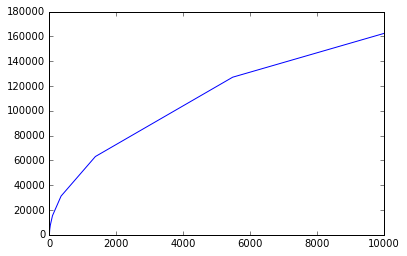

In [57]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot([util(x) for x in range(1000, 10000000, 1000)])
print('Y axis is util(x); x axis is in thousands of dollars.')

Now I will define the function `EU`, which computes the [expected utility](http://wiki.lesswrong.com/wiki/Expected_utility) of the game:

In [58]:
def EU(P, U):
    "The expected utility of a probability distribution, given a utility function."
    return sum(P[e] * U(e) 
               for e in P)

In [59]:
EU(StP, util)

13.096907431492582

That says we should pay up to $13.10 to play the game, which sounds more reasonable than $27.49.

# Understanding St. Petersburg  through Simulation

Before I plunk down my $13, I'd like to understand the game better. I'll write a simulation of the game:

In [60]:
def flip(): return random.choice(('head', 'tail'))

def simulate_st_pete(limit=10**9):
    "Simulate one round of the St. Petersburg game, and return the payoff."
    pot = 2
    while flip() == 'head':
        pot = pot * 2
        if pot > limit:
            return limit
    return pot

I will run the simulation 100,000 times (with a random seed specified for reproducability) and make the results into a probability distribution:

In [61]:
random.seed(123456)

results = ProbDist(Counter(simulate_st_pete() for _ in range(100000)))
results

{2: 0.49755,
 4: 0.2506,
 8: 0.1259,
 16: 0.06322,
 32: 0.03151,
 64: 0.01607,
 128: 0.00751,
 256: 0.0037,
 512: 0.00191,
 1024: 0.00106,
 2048: 0.00045,
 4096: 0.00029,
 8192: 0.0001,
 16384: 6e-05,
 32768: 5e-05,
 65536: 1e-05,
 1048576: 1e-05}

The results are about what you would expect: about half the pots are 2, a quarter are 4, an eighth are 8, and higher pots are more and more unlikely.  Let's check expected utility and expected value:

In [62]:
EU(results, util), EV(results)

(13.2477575, 26.71606)

These are not too far off from the theoretial values.

To see better how things unfold, I will define a function to plot the running average of repeated rounds:

In [63]:
def running_averages(iterable):
    "For each element in the iterable, yield the mean of all elements seen so far." 
    total, n = 0, 0
    for x in iterable:
        total, n = total + x, n + 1
        yield total / n

def plot_running_averages(fn, n):
    "Plot the running average of calling the function n times."
    plt.plot(list(running_averages(fn() for _ in range(n))))

Let's do ten repetitions of plotting the running averages of 100,000 rounds:

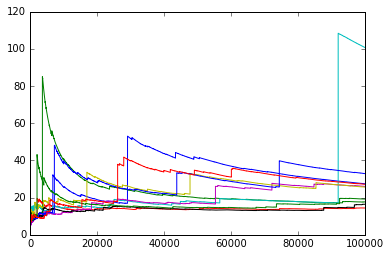

In [64]:
random.seed('running')

for i in range(10):
    plot_running_averages(simulate_st_pete, 100000);

What can we see from this?  Nine of the 10 repetitions have a final expected value payoff (after 100,000 rounds) between 10 and 35. So a price around $13 still seems reasonable. One outlier has an average payoff just over 100, so if you are feeling lucky you might be willing to pay more than $13.

# The Ellsburg Paradox

The [Ellsburg Paradox](https://en.wikipedia.org/wiki/Ellsberg_paradox) has it all: an urn problem; a paradox; a conclusion that can only be resolved through psychology, not  mathematics alone; and a colorful history with an inventor, [Daniel Ellsburg](https://en.wikipedia.org/wiki/Daniel_Ellsberg), who went on to become the releaser of the [Pentagon Papers](https://en.wikipedia.org/wiki/Pentagon_Papers).  The paradox is as follows:

> An urn contains 33 red balls and 66 other balls that are either black or yellow. You don't know the mix of black and yellow, just that they total 66. A single ball is drawn at random. You are asked which of these two gambles you would prefer:
- **R**: Win 100 for a red ball.
- **B**: Win 100 for a black ball.

> Separately, you are also asked which of these two gambles you prefer:
- **RY**: Win 100 for a red or yellow ball.
- **BY**: Win 100 for a black or yellow ball.

Many people reason as follows: 
- **R**: I win 1/3 of the time
- **B**: I win somewhere between 0 and 2/3 of the time, but I'm not sure of the probability. 
- **RY**: I win at least 1/3 of the time and maybe up to 100% of the time; I'm not sure. 
- **BY**: I win 2/3 of the time. 
- Overall, I prefer the relative certainty of **R** over **B** and of **BY** over **RY**.

The paradox is that, from an expected utility point of view, that reasoning is inconsistent, no matter what the mix of black and yellow balls is (or no matter what you believe the mix might be).  **RY** and **BY** are just the same gambles as **R** and **B**, but with an additional 100 for a yellow ball. So if you prefer **R** over **B**, you should prefer **RY** over **BY** (and if you prefer **B** over **R** you should prefer **BY** over **RY**), for any possible mix of black and yellow balls.

Let's demonstrate. For each possible number of black balls (on the *x* axis), we'll plot the expected value of each of the four gambles; **R** as a solid red line, **B** as a solid black line, **RY** as a dotted red line, and **BY** as a dotted black line:

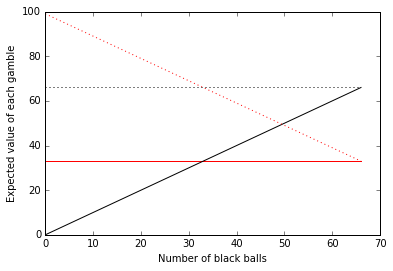

In [65]:
def ellsburg():
    show('R', 'r')
    show('B', 'k')
    show('RY', 'r:')
    show('BY', 'k:')
    plt.xlabel('Number of black balls')
    plt.ylabel('Expected value of each gamble')
    
blacks   = list(range(67))
all_urns = [Counter(R=33, B=b, Y=66-b) for b in blacks]
    
def show(colors, line):
    scores = [score(colors, urn) for urn in all_urns]
    plt.plot(blacks, scores, line)
    
def score(colors, urn): return sum(urn[c] for c in colors)

ellsburg()

We see that for any number of black balls up to 33, the solid red line is above the solid black line, which means **R** is better than **B**. The two gambles are equal with 33 black balls, and from there on, **B** is better than **R**.

Similarly, up to 33 black balls, the dashed red line is above the dashed black line, so **RY** is better than **BY**. They are equal at 33, and after that, **BY** is better than **RY**. So in summary, **R** > **B** if and only if **RY** > **BY**.

It is pretty clear that this holds for every possible mix of black and yellow balls, taken one at a time. But what if you believe that the mix might be one of several possibilities? For example, if we assume that any number of black balls from 0 to 66 is equally likely, then we can use a function, `expected_score` to give the expected return for a gamble (as specified by the colors in the gamble), averaged over a collection of possible urns, each with a different black/yellow mix:

In [66]:
def expected_score(colors, urns): 
    return sum(score(colors, urn) for urn in urns) / len(urns)

def compare(urns):
    for colors in ('R', 'B', 'RY', 'BY'):
        print(colors.ljust(2), expected_score(colors, urns))
        
compare(all_urns)

R  33.0
B  33.0
RY 66.0
BY 66.0


This says that **B** and **R** have an equal expected return, as do  **BY** and **RY**.

Now imagine that you believe that any mix is possible, but that a majority of black balls is more likely, in particular that the urns in the second half of the list of `all_urns` are twice as likely as those in the first half. Then we will see that **B** > **R** and **BY** > **RY**:

In [67]:
compare(all_urns[:33] + 2 * all_urns[33:])

R  33.0
B  38.554455445544555
RY 60.445544554455445
BY 66.0


If we believe the first half of the list (with fewer black balls) is twice as likely, we get this:

In [68]:
compare(2 * all_urns[:33] + all_urns[33:])

R  33.0
B  27.39
RY 71.61
BY 66.0


This time the preferences are reversed for both gambles, **R** > **B** and **RY** > **BY**.

So why do many people prefer **R** > **B** and **BY** > **RY**? One explanation is *risk aversion*; it feels safer to take a definite 1/3 chance of winning, rather than a gamble that might be as good as 2/3, but might be as bad as 0. This is irrational thinking (in the sense that those who follow this strategy will win less), but people are sometimes irrational.

# Simpson's Paradox

This has nothing to do with the TV show. D'oh! In 1951, statistician [Edward Simpson](https://en.wikipedia.org/wiki/Edward_H._Simpson) (who worked with Alan Turing at Bletchley Park during World War II), noted that it is possible to take a sample space in which **A** is better than **B**, and split it into two groups, such that **B** is better than **A** in both groups.  

For example, here is data from trials of two treatments for kidney stones, **A** and **B**, separated into two subgroups or cases: first, for small kidney stones, and second for large ones. In all cases we record the number of good and bad outcomes of the treatment:

In [69]:
# Good and bad outcomes for kidney stone treatments A and B,
# each in two cases: [small_stones, large_stones]
A = [Counter(good=81,  bad=6),  Counter(good=192, bad=71)]
B = [Counter(good=234, bad=36), Counter(good=55, bad=25)]

def success(case): return ProbDist(case)['good']

Let's compare probabilities of success:

In [70]:
[success(case) for case in A]

[0.9310344827586207, 0.7300380228136882]

In [71]:
[success(case) for case in B]

[0.8666666666666667, 0.6875]

We see that for small stones, **A** is better, 93% to 87%, and for large stones, **A** is also better, 75% to 69%. So **A** is better no matter what, right?

Not so fast.

We can add up `Counter`s to get the overall success rate for **A** and **B**, over all cases:

In [72]:
success(A[0] + A[1])

0.78

In [73]:
success(B[0] + B[1])

0.8257142857142857

Overall, **B** is more successful, 83% to 78%, even though **A** is better in both cases. So if you had kidney stones, and you want the highest chance of success, which treatment would you prefer? If you knew you had small stones (or large stones), the evidence supports **A**. But if the size was unknown, does that mean you should prefer **B**? Analysts agree that the answer is no, you should stick with **A**. The only reason why **B** has a higher overall success rate is that doctors choose to do **B** more often on the easier, small stone cases, and reserve **A** for the harder, large stone cases. **A** is better, but it has a lower overall percentage because it is given the difficult patients.

Here's another example, showing the batting averages for two baseball players, Derek Jeter and David Justice, for the years 1995 and 1996 (I should say that Justice is considered a very good player, but Jeter is considered even better, a sure-bet future Hall of Fame player):

In [74]:
Jeter   = [Counter(hit=12,  out=36),  Counter(hit=183, out=399)]
Justice = [Counter(hit=104, out=307), Counter(hit=45,  out=95)]

def BA(case): "Batting average"; return ProbDist(case)['hit']

In [75]:
[BA(year) for year in Jeter]

[0.25, 0.31443298969072164]

In [76]:
[BA(year) for year in Justice]

[0.25304136253041365, 0.32142857142857145]

So Justice had a higher batting average than Jeter for both 1995 and 1996.  Let's check overall:

In [77]:
BA(Jeter[0] + Jeter[1])

0.30952380952380953

In [78]:
BA(Justice[0] + Justice[1])

0.27041742286751363

Overall, Jeter had a significantly higher batting average.  How did Jeter manage to do worse both years, then? Because in 1995, Jeter was injured for much of the year, and his low batting average was over a small number of at-bats. In 1996, Jeter was healthy, but Justice was injured for much of the year; however he managed a high average in his few at-bats.

For the kidney stone data, we trust the individual cases, not the overall, because there are biases that lead to patients being assigned to one treatment or the other. For the batting average data, we trust the overall numbers, because there are no such biases, and because larger numbers lead to a closer approximation to a true value. The data alone can't tell you what to believe; you need the story (and the model) behind the data as well.

# Conclusion

We've seen how to manage probability paradoxes. Just be explicit about what the problem says, and then methodical about defining the sample space, and finally be careful in counting the number of outcomes in the numerator and denominator.  But the bigger lesson is: treat those around you as reasonable people, and when they have different opinions, try to discover what problem they are  solving.

*Note*: Mohammed El-Beltagy created a very nice [translation of an earlier version of this page to Julia](http://nbviewer.ipython.org/gist/mbeltagy/3ba5f77da6382da192c3). 
.